In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import re
import pdb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import rc
rc('text', usetex=False)
from matplotlib.colors import to_rgb

from skimage.transform import resize
from skimage.io import imread
from skimage.metrics import structural_similarity as ssim

from polyphase.parallel import get_distance_matrix

from sklearn.cluster import SpectralClustering
from scipy.sparse import csgraph
from scipy.linalg import eigvalsh

In [7]:
# load the csv file with HTE data
allsys_df = pd.read_pickle('../expts/data/allsys_df.pkl')
allsys_df.head()

,solvent,SM,polymer,chi12,chi13,chi23,delta_solv,delta_SM,delta_polymer
0,0,PC61BM,MDMO-PPV,0.475591,1.882709,2.458401,"[15.5, 10.4, 7.0]","[19.89, 5.68, 3.64]","[19.06, 5.62, 5.28]"
1,0,PC61BM,MEH-PPV,0.501121,1.955963,2.458401,"[15.5, 10.4, 7.0]","[19.89, 5.68, 3.64]","[19.06, 5.38, 5.44]"
2,0,PC61BM,P3HT,0.733347,3.564506,2.458401,"[15.5, 10.4, 7.0]","[19.89, 5.68, 3.64]","[18.56, 2.88, 3.19]"
3,0,PC61BM,PFO,0.774861,3.277155,2.458401,"[15.5, 10.4, 7.0]","[19.89, 5.68, 3.64]","[18.55, 2.8, 4.51]"
4,0,PC61BM,PM6,0.495941,3.441680,2.458401,"[15.5, 10.4, 7.0]","[19.89, 5.68, 3.64]","[19.98, 3.72, 3.44]"


In [8]:
def get_batch_of_phasediags(smstr, polymerstr):
    sys_df = allsys_df[(allsys_df['SM']==smstr) & (allsys_df['polymer']==polymerstr)]
    filename_list = []
    for _,row in sys_df.iterrows():
        fname = '../figures/hteplots/{}_{}_{}.png'.format(row['solvent'], row['SM'], row['polymer'])
        filename_list.append(fname)
    
    return filename_list, sys_df

def get_ssim_distance(file0, file1):
    """ Given two image file names in file0, file1 compute distance"""
    
    img0 = imread(file0)
    img1 = imread(file1)
    img0 = resize(img0, (64,64))
    img1 = resize(img1, (64,64))
    d = ssim(img0, img1, multichannel=True)
    
    return 1-d


In [5]:
print('small molecules : ',  allsys_df['SM'].unique())
print('polymers: ', allsys_df['polymer'].unique())

small molecules :  ['PC61BM' 'PC71BM' 'DPP(TBFu)2' 'F8-NODIPS' 'DPP(PhTT)2' 'Y6']
polymers:  ['MDMO-PPV' 'MEH-PPV' 'P3HT' 'PFO' 'PM6']


# When working with a single system
smstr = 'Y6'
polymerstr  = 'PM6'
files, sys_df = get_batch_of_phasediags(smstr, polymerstr)
print('Total of {} phase diagrams'.format(len(files)))

M = get_distance_matrix(files, get_ssim_distance)

# create the affinity matrix
delta = 1/len(files)
X = np.exp(- M ** 2 / (2. * delta ** 2))

In [6]:
# When working with pre-computed distance matrix

with open('../expts/data/hte_distance.pkl', 'rb') as handle:
    out = pickle.load(handle)
    
sys_df = out['df']
M = out['M']
delta = 1/len(sys_df)
X = np.exp(- M ** 2 / (2. * delta ** 2))
print(X.shape)

(172, 172)


In [121]:
X = np.array([[1.        , 0.99995146, 0.9954    , 0.99985552, 0.99985551,
        0.24274782],
       [0.99995146, 1.        , 0.99522403, 0.99990945, 0.99990945,
        0.2430543 ],
       [0.9954    , 0.99522403, 1.        , 0.9927409 , 0.99274048,
        0.21867312],
       [0.99985552, 0.99990945, 0.9927409 , 1.        , 1.        ,
        0.24577012],
       [0.99985551, 0.99990945, 0.99274048, 1.        , 1.        ,
        0.2457703 ],
       [0.24274782, 0.2430543 , 0.21867312, 0.24577012, 0.2457703 ,
        1.        ]])

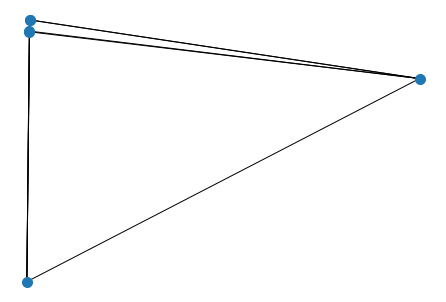

In [122]:
# using networkx spectral embedding
import networkx as nx
G = nx.from_numpy_matrix(X)
options = {"node_color": "C0", "node_size": 100}

nx.draw_spectral(G,**options)

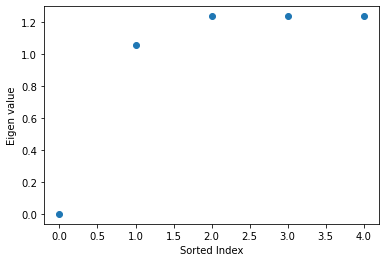

In [123]:
laplacian = csgraph.laplacian(X, normed=True)
eigen_values = eigvalsh(laplacian)

fig, ax = plt.subplots()
num_eigs = 5
ax.scatter(np.arange(num_eigs),eigen_values[:num_eigs])
ax.set_xlabel('Sorted Index')
ax.set_ylabel('Eigen value')
plt.show()

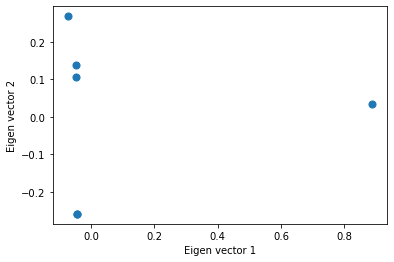

In [124]:
# laplacian eigenmaps
from sklearn.manifold import spectral_embedding
from sklearn.cluster import spectral_clustering
embedding = spectral_embedding(X,n_components=2, norm_laplacian=True, random_state=0, drop_first=True)

fig, ax = plt.subplots()
ax.scatter(embedding[:,0], embedding[:,1],s=50)
ax.set_xlabel('Eigen vector 1')
ax.set_ylabel('Eigen vector 2')
plt.show()

In [125]:
embedding

array([[-0.04649014,  0.13761328],
       [-0.04612298,  0.10516858],
       [-0.0733839 ,  0.26849897],
       [-0.04271957, -0.25907289],
       [-0.04271932, -0.25912586],
       [ 0.8883083 ,  0.03435324]])

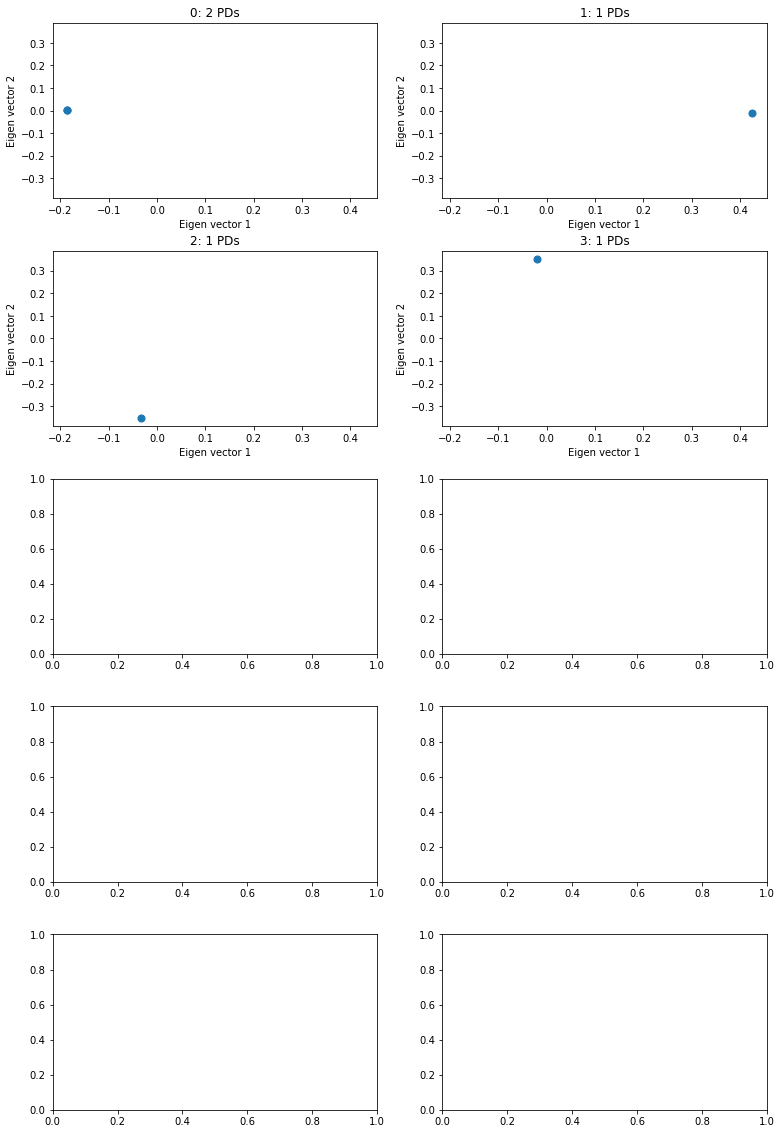

In [118]:
req_clusters = 4
labels = spectral_clustering(X, n_clusters=req_clusters,n_components = 2,
                                assign_labels="kmeans",random_state=0)

num_clusters = len(np.unique(labels))
fig,axs = plt.subplots(5,2, figsize=(4*2*1.6, 4*5))
fig.subplots_adjust(wspace=0.2, hspace=0.3)
axs = axs.flatten()
for label in range(num_clusters):
    axs[label].scatter(embedding[labels==label,0], embedding[labels==label,1],s=50)
    axs[label].set_xlabel('Eigen vector 1')
    axs[label].set_ylabel('Eigen vector 2')
    axs[label].set_title('{}: {} PDs'.format(label, np.sum(labels==label)))
    axs[label].set_xlim(ax.get_xlim()) 
    axs[label].set_ylim(ax.get_ylim())
    
plt.show()

In [13]:
from collections import Counter 
delta_sm = []
for key in Counter([tuple(i) for i in sys_df['delta_SM']]):
    delta_sm.append(list(key))
delta_polymer = []
for key in Counter([tuple(i) for i in sys_df['delta_polymer']]):
    delta_polymer.append(list(key))    
delta_solv = np.asarray(sys_df['delta_solv'].to_list())

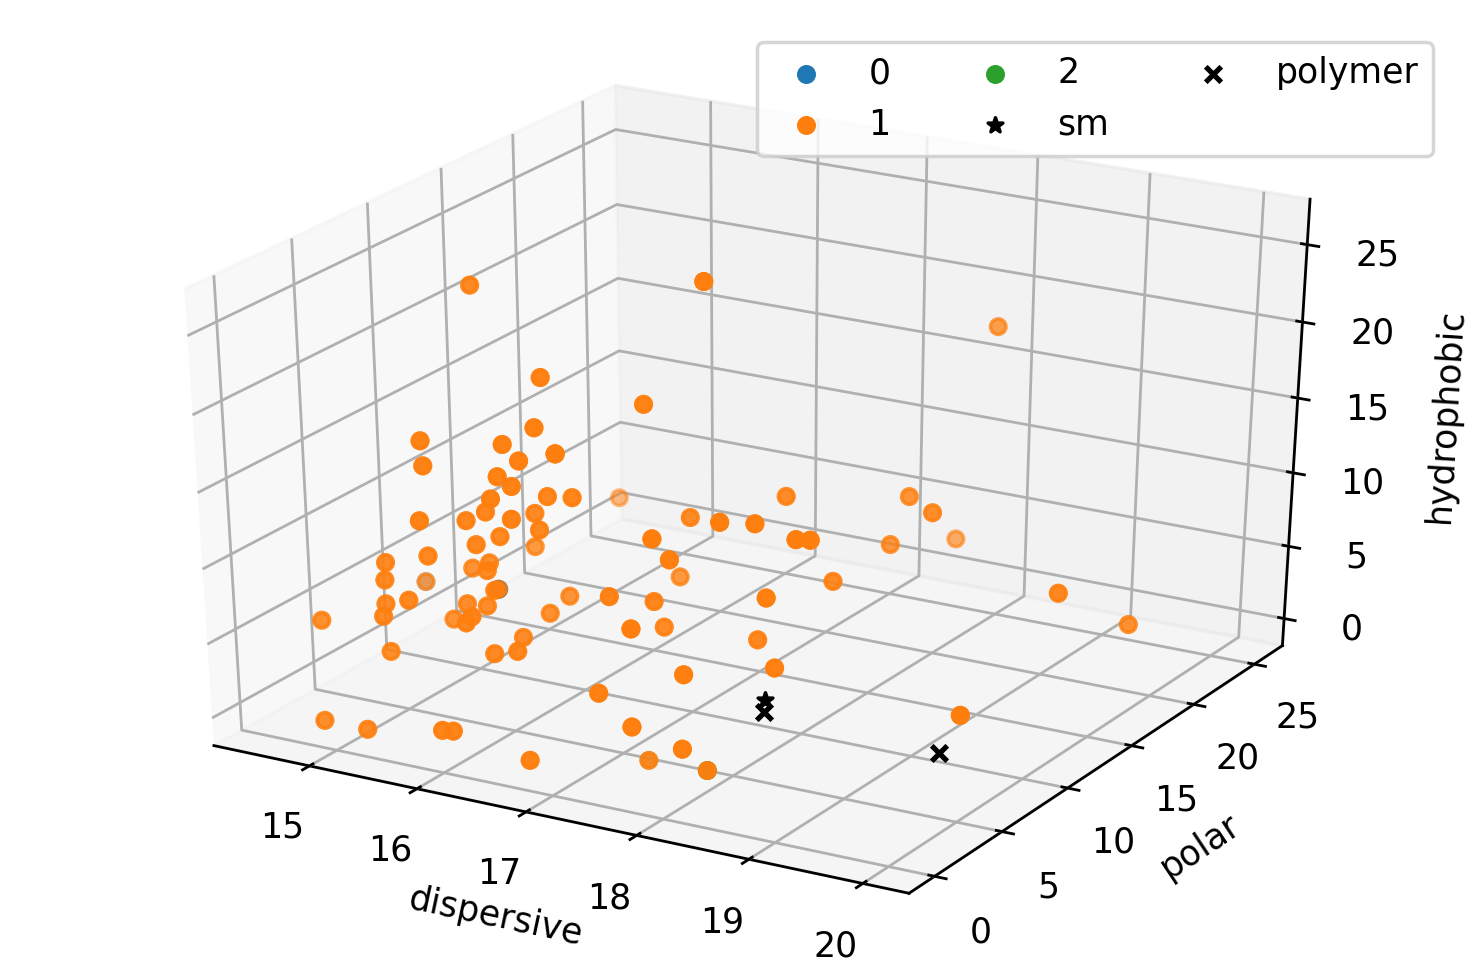

In [103]:
fig = plt.figure(dpi=250)
ax = fig.add_subplot(projection='3d')
for label in range(num_clusters):
    ax.scatter(delta_solv[labels==label, 0], delta_solv[labels==label,1],
               delta_solv[labels==label, 2], label=str(label))

for i,value in enumerate(delta_sm):    
    ax.scatter(value[0],value[1],value[2], marker='*', color='k', label='sm' if i==0 else "")
for i, value in enumerate(delta_polymer):
    ax.scatter(value[0],value[1],value[2], marker='x', color='k', label='polymer'if i==0 else "")

ax.set_xlabel('dispersive')
ax.set_ylabel('polar')
ax.set_zlabel('hydrophobic')
ax.legend(ncol=3)
plt.tight_layout()
plt.show()

In [153]:
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline
def plot_clustered_diagrams_grid(cluster_id):
    cluster_diags = sys_df.loc[labels==cluster_id]
    num_diags = len(cluster_diags)
    fig = plt.figure(figsize=(24, 4.), dpi=250)
    num_rows = min(10,int(np.floor(num_diags/5)+1))

    grid = ImageGrid(fig, 111,nrows_ncols=(num_rows, 5), axes_pad=(0.1,0.1))
    for ax, (_,row) in zip(grid, cluster_diags.iterrows()):
        fname = '../figures/hteplots/{}_{}_{}.png'.format(row['solvent'],row['SM'],row['polymer'])
        img = plt.imread(fname)
        ax.imshow(img)
        ax.axis('off')

    plt.axis('off')
    plt.show()
    


In [ ]:
plot_clustered_diagrams_grid(7)

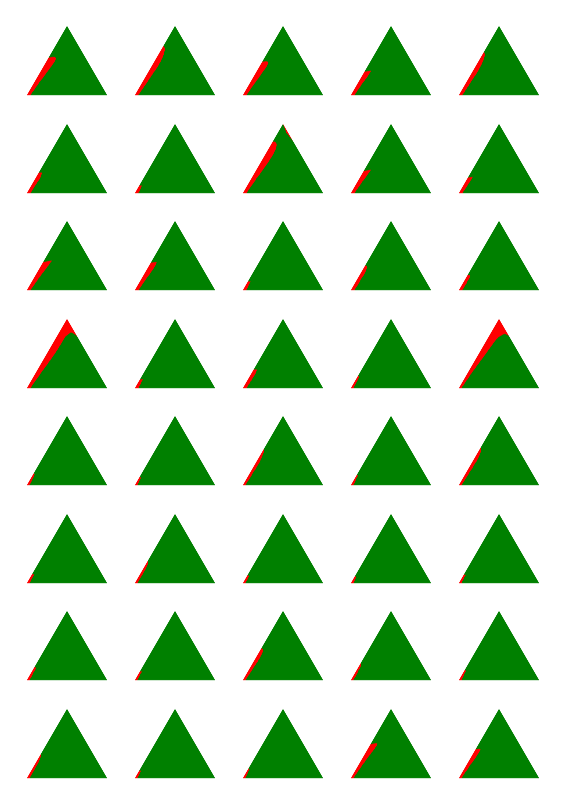

In [137]:
plot_clustered_diagrams_grid(0)

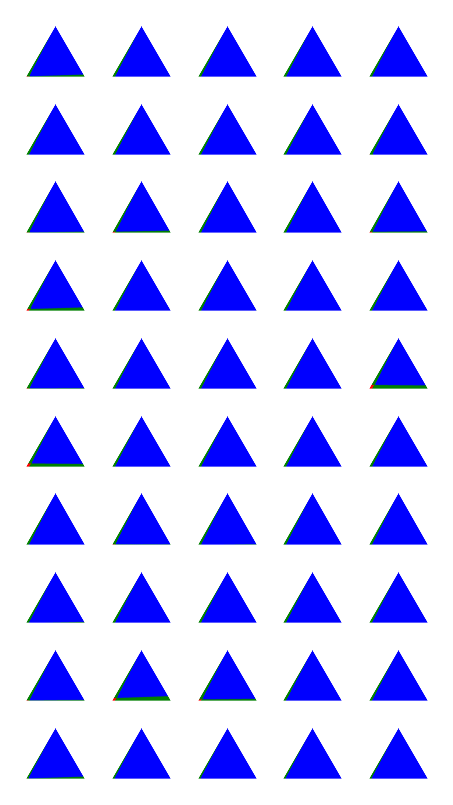

In [138]:
plot_clustered_diagrams_grid(5)

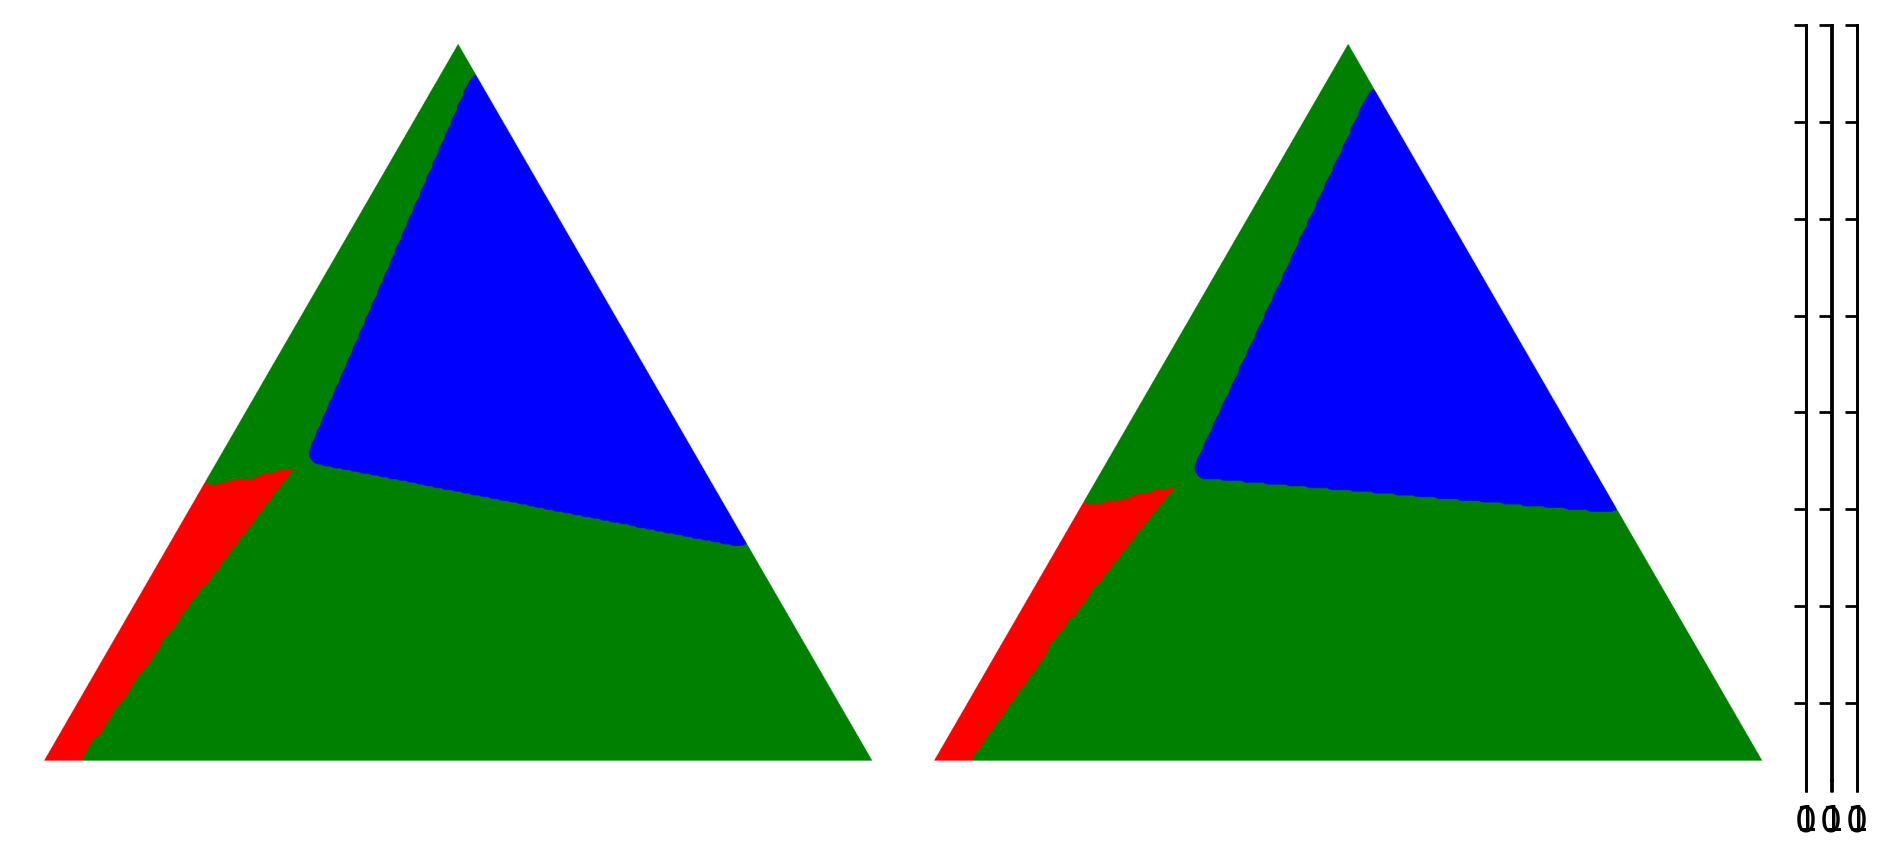

In [154]:
plot_clustered_diagrams_grid(2)

In [32]:
import itertools

def get_multiple_systems(systems):
    """ 
    Given a list of (small molecule, polemer) tuples, 
    returns portion of the dataframe with the phase diagrams of the system
    
    """
    files, sys_df = [], []
    for indx, (i,j) in enumerate(systems):
        _files, _sys_df = get_batch_of_phasediags(i, j)
        files.append(_files)
        sys_df.append(_sys_df)
        print(indx, i, j)

    sys_df = pd.concat(sys_df)
    files = list(itertools.chain.from_iterable(files))
    
    assert len(sys_df)==86*len(systems), "Expected {} phase diagrams got {}".format(86*len(systems),len(sys_df))
    
    return files, sys_df

files, sys_df = get_multiple_systems([('Y6','PFO'), ('Y6','PM6')])


0 Y6 PFO
1 Y6 PM6


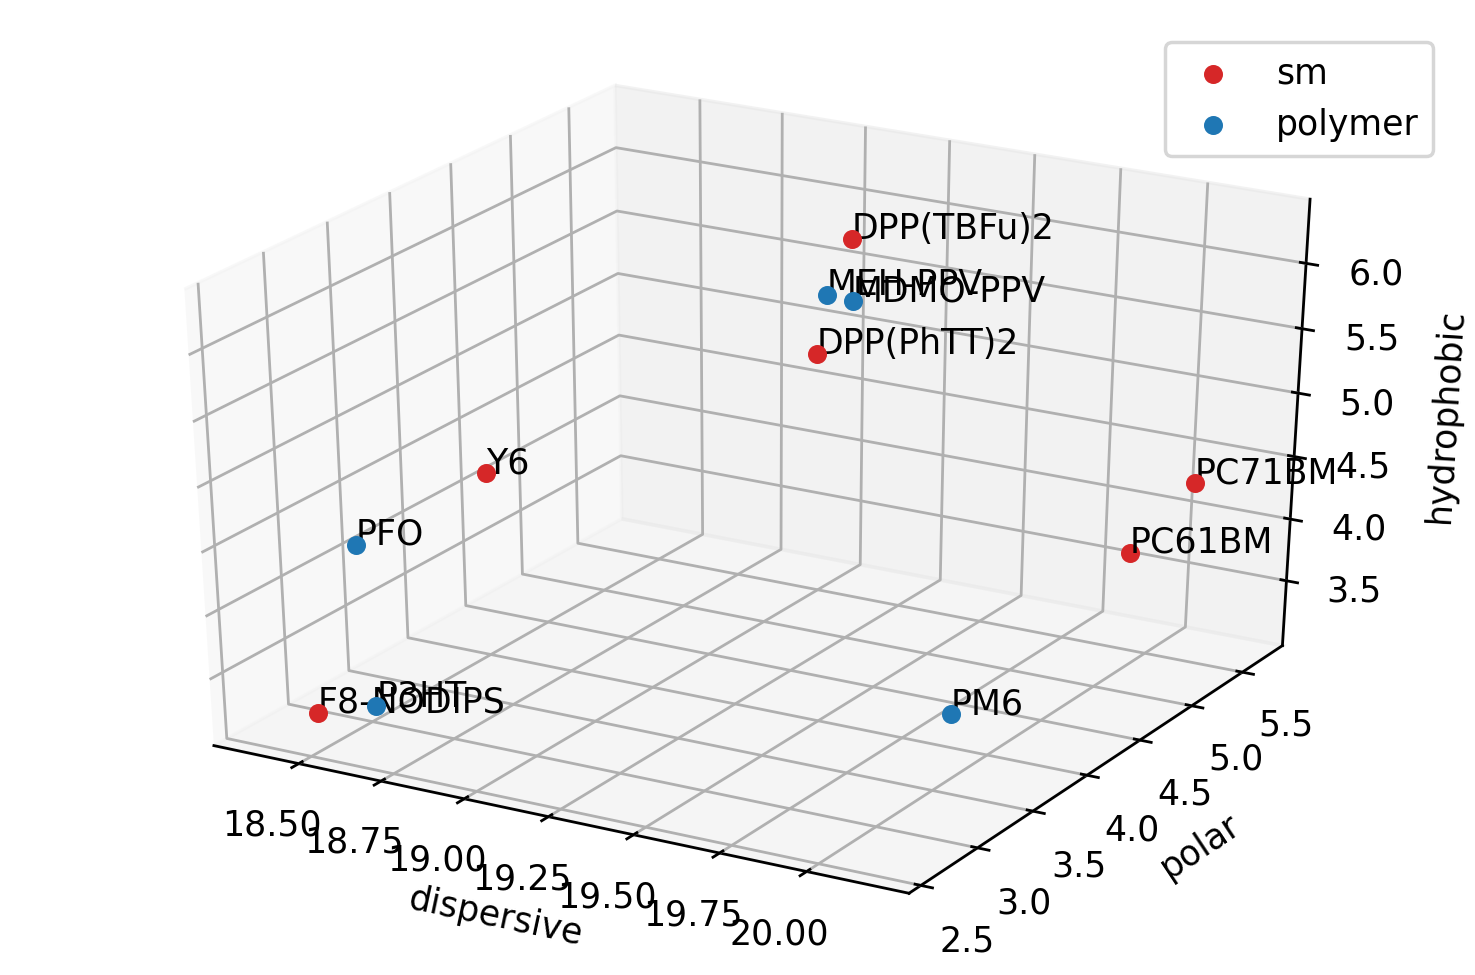

In [29]:
fig = plt.figure(dpi=250)
ax = fig.add_subplot(projection='3d')
for i, (name, _df) in enumerate(allsys_df.groupby('SM')):
    value = _df['delta_SM'].iloc[0]  
    ax.scatter(value[0],value[1],value[2], color='tab:red', label='sm' if i==0 else "")
    ax.text(value[0],value[1],value[2], name)
    
for i, (name, _df) in enumerate(allsys_df.groupby('polymer')):
    value = _df['delta_polymer'].iloc[0]  
    ax.text(value[0],value[1],value[2], name)
    ax.scatter(value[0],value[1],value[2], color='tab:blue', label='polymer'if i==0 else "")

ax.set_xlabel('dispersive')
ax.set_ylabel('polar')
ax.set_zlabel('hydrophobic')
ax.legend()
plt.tight_layout()
plt.show()